## 1. Simple model

Commonly, infection numbers are assumed to have logistic growth:

$$ \frac{dn}{dt} = \alpha n \left(1 - \frac{n}{K} \right) $$

Where $n(t)$ is the number of infections at time $t$, $\alpha$ is the growth rate, and $K$ is the carrying capacity (the maximum number of people that can get infected).

Note that this model does not have a spatial component - it does not account for traffic from other regions into the study area.

In a first step, we'll use this model to capture infection numbers for all of Germany.

On 22nd of March 2020, measures have been introduced to reduce the spread of the corona virus. These measure primarily consist of reduced traffic, social distancing and individual hygiene. In our model, this process can be captured by allowing for another value of $\alpha$ from 22nd of March onwards. (In fact, those measures only fully take effect after that point, because many people will have been infected at some point before the 22nd, but only show symptoms after a certain incubation time.)

$$ 
\alpha(t) = 
\begin{cases}
    \alpha_0 \text{ if } t < t_0 \\
    \alpha_1 \text{ else}
\end{cases} 
$$

This model does better in fitting to cumulative data, but suffers from the same shortcomings as the simple model when it comes to deaggregated data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, animation
from IPython.display import HTML
import pandas as pd
import geopandas as gpd

In [3]:
from models import stepModel, minimize, msse, getMsseRelative
from plotting import plotSim, plotSimCuml, plotSimMulti, scatterHistory, video, getIndex

In [10]:
data = gpd.read_file('./data/landkreise_fallzahlen.json')
dateColNames = data.columns[6:-1]

In [11]:
incubationTime = 7
t_infectious = 14
t_curfew = getIndex('22.03.2020', dateColNames)
t_curfew_effect = t_curfew + incubationTime

In [19]:
n_obs = data[dateColNames].values
n0 = n_obs[:, 0]
population = data['population'].values
Ks = population

In [15]:
n_obs_cuml = np.sum(n_obs, axis=0).reshape((1, nrTimesteps))
population_cuml = np.sum(population)
K_cuml = population_cuml
n0_cuml = n_obs_cuml[:, 0]

In [16]:
alpha0_est = 0.2
alpha0_bounds = (0.001, 1)
alpha1_est = 0.1
alpha1_bounds = (0.001, 1)


results_step_cuml, _ = minimize(
    n_obs_cuml, stepModel, 
    [alpha0_est, alpha1_est], 
    [alpha0_bounds, alpha1_bounds], 
    [1, nrTimesteps, K_cuml, n0_cuml, t_curfew_effect, t_infectious], msse)
results_step_cuml

      fun: 813566416.3564276
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4930222.03445435,  486123.56185913])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 12
   status: 0
  success: True
        x: array([0.23655967, 0.23301014])

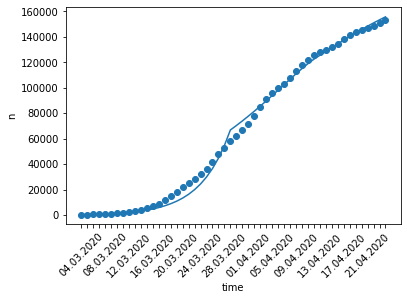

In [17]:
n_sim_step_cuml = stepModel(*(results_step_cuml.x), 1, nrTimesteps, K_cuml, n0_cuml, t_curfew_effect, t_infectious)
plotSimCuml(dateColNames, n_obs_cuml, n_sim_step_cuml)



This model does ok for cumulative data. But we'll see that results are terrible if we try to use the same model for deaggregated LKs. The reason is mostly n0: most LKs don't initially have any infections, so this model always predicts 0 for these LKs.

When used for deaggregated data, this model will effectively only calibrate on to those LKS with n0 != 0. Really, attempting to use this model for LKs is a gross abuse of its original intent. We'll do it anyway here, because it illustrates nicely the need for a spatial component in the model if we want to mirror local dynamics.

In [20]:
msseRelPop = getMsseRelative(population / 10000)
results_step, _ = minimize(
    n_obs_cuml, stepModel, 
    [alpha0_est, alpha1_est], 
    [alpha0_bounds, alpha1_bounds],
    [nrPlaces, nrTimesteps, Ks, n0, t_curfew_effect, t_infectious], msseRelPop)
results_step

      fun: 1187180574324.4802
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.57006104e+10, 4.44545654e+10])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 7
   status: 0
  success: True
        x: array([0.50757469, 0.33951577])

We can learn a few things from this:

  1. If we want to predict local values, we need to use a model that takes location and traffic explicitly into account.

  2. If we don't do that, we get a value for $\alpha$ that differs massively from the global one, because that non-global alpha is effectively only being calculated from the places that have `n0 != 0`

  3. Also note that this model, when used for cumulated vs. deaggregated data, has very different interpretations:
the model with cumulated data assumes perfect mixing between LKs, the model with deaggregated data assumes no mixing at all.